Ce Notebook présente le développement du Projet 6 - Parcours Data Scientist - OpenClassRooms

# Classifiez automatiquement des biens de consommation

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *

#On charge le dictionnaire de stopwords
#disponible dans la librairie nltk
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
#stopwords
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Classification

Nous en arrivons à la troisième partie. Pour résumé, nous avons effectué :
 1. L'extraction des features des données textes. La méthode TF-IDF avec bi-gramme s'avérant la plus efficace sur notre jeu de données
 2. L'extraction des features des images avec un algorithme d'extraction (ORB)
 3. L'extraction des features des images avec un CNN (VGG-16)
 
Nous devons maintenant construire notre jeu de données pour effectuer une classification multi-classes. Nous allons faire plusieurs itérations afin d'évaluer la plus performante :
 - Seulement les features textes
 - Features textes avec TF-IDF & features images avec ORB
 - Features textes avec TF-IDF & features images avec VGG-16

### Récupération des données vectorielles

Pour cette étape de préparation, nous allons reformater les données dans un dataframe propre à chaque extraction. Ensuite, suivant les itérations, nous concatènerons les dataframes pour le clustering.

In [298]:
def extract_data(col):
    
    v = np.column_stack(df_train[col].values.tolist())
    df = pd.DataFrame(v).T
    
    return df

In [ ]:
df_train = pd.read_csv("data_saved/train.csv")

In [325]:
df_train.head(1)

,description,product_category_tree,sous_cat_1,sous_cat_2,tf_idf,word2vec,image,image_grayscale,image_redim,image_redim_contrast,bovw,VGG16,resnet50
0,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",Furnishing,Curtains & Accessories,"[0.0, 0.0, 17.279644, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.09962364, 0.16940546, -0.0069218054, 0.115...",data/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,data/Images/Images_grayscale/55b85ea15a1536d46...,data/Images/Images_redim/55b85ea15a1536d46b719...,data/Images/Images_redim_contrast/55b85ea15a15...,"[3.0, 3.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 2.0, ...","[0.0, 0.0, 0.0, 0.0, 9.618563, 0.0, 0.0, 0.0, ...","[3.881091, 0.0, 0.0, 0.16341764, 0.17857587, 0..."


In [299]:
df_tfidf = extract_data("tf_idf")
df_word2vec = extract_data("word2vec")
df_bovw = extract_data("bovw")
df_vgg16 = extract_data("VGG16")
df_resnet50 = extract_data("resnet50")

print("Taille vecteurs tfidf :", df_tfidf.shape[1])
print("Taille vecteurs word2vec :", df_word2vec.shape[1])
print("Taille vecteurs bovw :", df_bovw.shape[1])
print("Taille vecteurs VGG16 :", df_vgg16.shape[1])
print("Taille vecteurs Resnet50 :", df_resnet50.shape[1])

Taille vecteurs tfidf : 2371
Taille vecteurs word2vec : 100
Taille vecteurs bovw : 1000
Taille vecteurs VGG16 : 25088
Taille vecteurs Resnet50 : 100352


### Construction jeu de données

Concaténation des dataframes avec réalisation d'une ACP afin de faire une réduction dimensionnelle de nos itérations. Cela permettra de simplifier les modèles de clustering et d'améliorer leurs performances.

In [300]:
def concat_df(df1, df2):
    
    df = pd.concat([df1, df2], axis=1, ignore_index=True)
    
    return df

#### Définition ACP

In [301]:
def display_scree_plot(acp):
    scree = acp.explained_variance_ratio_*100
    #print(scree)
    #print("Le premier plan factoriel représente {} % de la variance totale.".format(round(scree[0] + scree[1],2)))
    #print("Le deuxième plan factoriel représente {} % de la variance totale.".format(round(scree[2] + scree[3],2)))
    #print("Le troisième plan factoriel représente {} % de la variance totale.".format(round(scree[4] + scree[5],2)))
    plt.figure(figsize=(8, 8))
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [302]:
def application_pca(df, taux):
    
    #n_comp = 6
    pca = PCA(0.9)     #n_components=n_comp)

    X_pca =  pd.DataFrame(pca.fit_transform(df))

    #On appelle la fonction qui trace la courbe des éboulis des valeurs propres
    #display_scree_plot(pca)

    return X_pca

In [322]:
df

,sous_cat_1,image_redim_contrast
0,Furnishing,data/Images/Images_redim_contrast/55b85ea15a15...
1,Care,data/Images/Images_redim_contrast/7b72c92c2f6c...
2,Care,data/Images/Images_redim_contrast/64d5d4a25824...
3,Furnishing,data/Images/Images_redim_contrast/d4684dcdc759...
4,Furnishing,data/Images/Images_redim_contrast/6325b6870c54...
...,...,...
1045,Care,data/Images/Images_redim_contrast/958f54f4c46b...
1046,Care,data/Images/Images_redim_contrast/fd6cbcc22efb...
1047,Care,data/Images/Images_redim_contrast/5912e037d127...
1048,Care,data/Images/Images_redim_contrast/c3edc504d1b4...


#### Définition NMF

In [303]:
def application_NMF(df, comp):

    nmf = NMF(n_components=comp, solver="mu")

    W = nmf.fit_transform(df)

    H = nmf.components_
    
    df = pd.DataFrame(W)
    
    return df

In [330]:
import sklearn

In [332]:
print("Version pd:", pd.__version__)
print("Version np:", np.__version__)
print("Version sns:", sns.__version__)
print("Version cv2:", cv2.__version__)
print("Version sklearn:", sklearn.__version__)

Version pd: 1.5.3
Version np: 1.24.3
Version sns: 0.12.2
Version cv2: 4.8.1
Version sklearn: 1.3.0


#### Construction des itérations

In [333]:
%%time

from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

taux_pca = 0.9
nb_comp_nmf = 7

df_iter_texte = application_NMF(df_tfidf, nb_comp_nmf)
df_iter_bovw = application_NMF(df_bovw, nb_comp_nmf)
df_iter_vgg16 = application_NMF(df_vgg16, nb_comp_nmf)
df_iter_resnet50 = application_NMF(df_resnet50, nb_comp_nmf)

# Texte = Tfidf | Images = bovw 
df_iter1 = concat_df(df_tfidf, df_bovw)
df_iter1_pca = application_pca(df_iter1, taux_pca)
df_iter1_nmf = application_NMF(df_iter1, nb_comp_nmf)
print("Itération : Textes = Tfidf | Images = BoVW")
print("Nombre de features après PCA :", df_iter1_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
print("Nombre de features après NMF :", df_iter1_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = Tfidf | Images = VGG16 
df_iter2 = concat_df(df_tfidf, df_vgg16)
df_iter2_pca = application_pca(df_iter2, taux_pca)
df_iter2_nmf = application_NMF(df_iter2, nb_comp_nmf)
print("Itération : Textes = Tfidf | Images = VGG16")
print("Nombre de features après PCA :", df_iter2_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
print("Nombre de features après NMF :", df_iter2_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = word2vec | Images = bovw
df_iter3 = concat_df(df_word2vec, df_bovw)
df_iter3_pca = application_pca(df_iter3, taux_pca)
#df_iter3_nmf = application_NMF(df_iter3, nb_comp_nmf)
print("Itération : Textes = Word2Vec | Images = BoVW")
print("Nombre de features après PCA :", df_iter3_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
#print("Nombre de features après NMF :", df_iter3_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = Word2vec | Images = VGG16 
df_iter4 = concat_df(df_word2vec, df_vgg16)
df_iter4_pca = application_pca(df_iter4, taux_pca)
#df_iter4_nmf = application_NMF(df_iter4, nb_comp_nmf)
print("Itération : Textes = Word2Vec | Images = VGG16")
print("Nombre de features après PCA :", df_iter4_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
#print("Nombre de features après NMF :", df_iter4_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = word2vec | Images = VGG16_NMF
df_iter5 = concat_df(df_word2vec, application_NMF(df_vgg16, nb_comp_nmf))
print("Itération : Textes = Word2Vec | Images = VGG16 avec NMF")
print("Nombre de features après NMF :", df_iter5.shape)

# Texte = Tfidf | Images = ResNet50 
df_iter6 = concat_df(df_tfidf, df_resnet50)
df_iter6_pca = application_pca(df_iter6, taux_pca)
df_iter6_nmf = application_NMF(df_iter6, nb_comp_nmf)
print("Itération : Textes = Tfidf | Images = ResNet50")
print("Nombre de features après PCA :", df_iter6_pca.shape, "pour", taux_pca * 100, "% d'informations conservées.")
print("Nombre de features après NMF :", df_iter6_nmf.shape, "pour", nb_comp_nmf, "composantes.")

# Texte = word2vec | Images = ResNet50_NMF
df_iter7 = concat_df(df_word2vec, application_NMF(df_resnet50, nb_comp_nmf))
print("Itération : Textes = Word2Vec | Images = ResNet50 avec NMF")
print("Nombre de features après NMF :", df_iter7.shape)

Itération : Textes = Tfidf | Images = BoVW
Nombre de features après PCA : (1050, 420) pour 90.0 % d'informations conservées.
Nombre de features après NMF : (1050, 7) pour 7 composantes.
Itération : Textes = Tfidf | Images = VGG16
Nombre de features après PCA : (1050, 578) pour 90.0 % d'informations conservées.
Nombre de features après NMF : (1050, 7) pour 7 composantes.
Itération : Textes = Word2Vec | Images = BoVW
Nombre de features après PCA : (1050, 342) pour 90.0 % d'informations conservées.
Itération : Textes = Word2Vec | Images = VGG16
Nombre de features après PCA : (1050, 577) pour 90.0 % d'informations conservées.
Itération : Textes = Word2Vec | Images = VGG16 avec NMF
Nombre de features après NMF : (1050, 107)
Itération : Textes = Tfidf | Images = ResNet50
Nombre de features après PCA : (1050, 665) pour 90.0 % d'informations conservées.
Nombre de features après NMF : (1050, 7) pour 7 composantes.
Itération : Textes = Word2Vec | Images = ResNet50 avec NMF
Nombre de features apr

In [346]:
%%time

from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 

nb_iterations = 14

df_score = pd.DataFrame(columns=["iteration", "bayes", "tree", "svm", "rf","GBC"], index=range(nb_iterations))

for i in range(1, nb_iterations+1):
    
    if i == 1:
        X = df_iter_texte
    elif i == 2:
        X = df_iter_bovw
    elif i == 3:
        X = df_iter_vgg16
    elif i == 4:
        X = df_iter_resnet50
    elif i == 5:
        X = df_iter1_pca
#         X=X
    elif i == 6:
        X = df_iter1_nmf
    elif i == 7:
        X = df_iter2_pca
#         X=X
    elif i == 8:
        X = df_iter2_nmf
    elif i == 9:
        X = df_iter3_pca
#         X=X
    elif i == 10:
        X = df_iter4_pca
#         X=X
    elif i == 11:
        X = df_iter5
#         X=X
    elif i == 12:
        X = df_iter6_pca
#         X=X
    elif i == 13:
        X = df_iter6_nmf
    elif i == 14:
        X = df_iter7
#         X=X
    
    y = des_target
    
    # dividing X, y into train and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 
  
    # training a DescisionTreeClassifier 
    dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    # model accuracy for X_test   
    accuracy_dtree = dtree_model.score(X_test, y_test) 
    
    # training a linear SVM classifier 
    svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
    svm_predictions = svm_model_linear.predict(X_test) 
    # model accuracy for X_test   
    accuracy_svm = svm_model_linear.score(X_test, y_test) 

#     # training a KNN classifier 
#     knn = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train) 
#     knn_predictions = knn.predict(X_test) 
#     # accuracy on X_test 
#     accuracy_knn = knn.score(X_test, y_test)
    from sklearn.ensemble import RandomForestClassifier

    # Entraînement d'un modèle RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    rf_classifier.fit(X_train, y_train)
    rf_predictions = rf_classifier.predict(X_test)

    # Précision sur X_test
    accuracy_rf = rf_classifier.score(X_test, y_test)
  
    from sklearn.ensemble import GradientBoostingClassifier

    # Entraînement d'un modèle GradientBoostingClassifier
    gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    gb_classifier.fit(X_train, y_train)
    gb_predictions = gb_classifier.predict(X_test)

    # Précision sur X_test
    accuracy_gb = gb_classifier.score(X_test, y_test)


    # training a Naive Bayes classifier 
    gnb = GaussianNB().fit(X_train, y_train) 
    gnb_predictions = gnb.predict(X_test) 
    # accuracy on X_test 
    accuracy_gnb = gnb.score(X_test, y_test)
    
    df_score["iteration"][i-1] = i
    df_score["bayes"][i-1] = round(accuracy_gnb, 2)
    df_score["tree"][i-1] = round(accuracy_dtree, 2)
    df_score["svm"][i-1] = round(accuracy_svm, 2)
    df_score["rf"][i-1] = round(accuracy_rf, 2)
    df_score["GBC"][i-1] = round(accuracy_gb, 2)
    
    print("---------------------------------------------")
    print("Itération ", i, ":")
    print("Accuracy du modèle naïf de Bayes :", round(accuracy_gnb, 2))
    print("Accuracy de l'arbre de décision :", round(accuracy_dtree, 2))
    print("Accuracy du SVM :", round(accuracy_svm, 2))
    print("Accuracy du RandomForestClassifier :", round(accuracy_rf, 2))
    print("Accuracy du GradientBoostingClassifier :", round(accuracy_gb, 2))


---------------------------------------------
Itération  1 :
Accuracy du modèle naïf de Bayes : 0.52
Accuracy de l'arbre de décision : 0.52
Accuracy du SVM : 0.53
Accuracy du RandomForestClassifier : 0.67
Accuracy du RandomForestClassifier : 0.67
---------------------------------------------
Itération  2 :
Accuracy du modèle naïf de Bayes : 0.19
Accuracy de l'arbre de décision : 0.19
Accuracy du SVM : 0.27
Accuracy du RandomForestClassifier : 0.22
Accuracy du RandomForestClassifier : 0.22
---------------------------------------------
Itération  3 :
Accuracy du modèle naïf de Bayes : 0.58
Accuracy de l'arbre de décision : 0.58
Accuracy du SVM : 0.64
Accuracy du RandomForestClassifier : 0.6
Accuracy du RandomForestClassifier : 0.6
---------------------------------------------
Itération  4 :
Accuracy du modèle naïf de Bayes : 0.71
Accuracy de l'arbre de décision : 0.71
Accuracy du SVM : 0.76
Accuracy du RandomForestClassifier : 0.71
Accuracy du RandomForestClassifier : 0.71
--------------

In [340]:
# %%time
# import pandas as pd
# from sklearn.metrics import confusion_matrix 
# from sklearn.model_selection import train_test_split 
# from sklearn.naive_bayes import GaussianNB 
# from sklearn.svm import SVC  # Importez la classe SVC
# from sklearn.tree import DecisionTreeClassifier 

# # Définissez le nombre d'itérations
# nb_iterations = 14

# # Créez un DataFrame pour stocker les résultats
# df_score = pd.DataFrame(columns=["iteration", "bayes", "tree", "svm"], index=range(nb_iterations))

# # Fonction pour entraîner et évaluer les modèles
# def train_and_evaluate_model(X_train, X_test, y_train, y_test):
#     # Entraînez un modèle de Bayes
#     gnb = GaussianNB().fit(X_train, y_train) 
#     accuracy_gnb = gnb.score(X_test, y_test)

#     # Entraînez un modèle d'arbre de décision
#     dtree_model = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train) 
#     accuracy_dtree = dtree_model.score(X_test, y_test)

#     # Entraînez un modèle SVM linéaire
#     svm_model_linear = SVC(kernel='linear', C=1).fit(X_train, y_train) 
#     accuracy_svm = svm_model_linear.score(X_test, y_test)

#     return accuracy_gnb, accuracy_dtree, accuracy_svm

# for i in range(1, nb_iterations+1):
#     # Assurez-vous d'avoir correctement défini X en fonction de la valeur de i

#     y = des_target
    
#     # Divisez X et y en données d'entraînement et de test
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
  
#     # Entraînez et évaluez les modèles
#     accuracy_gnb, accuracy_dtree, accuracy_svm = train_and_evaluate_model(X_train, X_test, y_train, y_test)
    
#     df_score["iteration"][i-1] = i
#     df_score["bayes"][i-1] = round(accuracy_gnb, 2)
#     df_score["tree"][i-1] = round(accuracy_dtree, 2)
#     df_score["svm"][i-1] = round(accuracy_svm, 2)
    
#     print("----------------------------------------------")
#     print("Itération", i, ":")
#     print("Accuracy du modèle naïf de Bayes:", round(accuracy_gnb, 2))
#     print("Accuracy de l'arbre de décision:", round(accuracy_dtree, 2))
#     print("Accuracy du SVM:", round(accuracy_svm, 2))


In [347]:
df_score

,iteration,bayes,tree,svm,rf,GBC
0,1,0.52,0.33,0.53,0.67,0.78
1,2,0.19,0.2,0.27,0.22,0.23
2,3,0.58,0.34,0.64,0.6,0.64
3,4,0.71,0.41,0.76,0.71,0.69
4,5,0.4,0.27,0.83,0.51,0.58
5,6,0.22,0.21,0.25,0.25,0.28
6,7,0.55,0.32,0.79,0.67,0.68
7,8,0.55,0.33,0.61,0.51,0.62
8,9,0.26,0.17,0.35,0.3,0.17
9,10,0.54,0.32,0.79,0.66,0.67


In [360]:
# fig, ax = plt.subplots(figsize=(20, 8))

# x = np.arange(1, nb_iterations+1)
# bar_width = 0.15

# for i in x:
    
#     bar1 = ax.bar(i-(1.5*bar_width),
#                  df_score.loc[df_score["iteration"] == i, "bayes"],
#                  width=bar_width,
#                   color="gray"
#                 )
#     bar2 = ax.bar(i-bar_width/2,
#                  df_score.loc[df_score["iteration"] == i, "tree"],
#                  width=bar_width,
#                   color="lightblue"
#                 )
#     bar3 = ax.bar(i+bar_width/2,
#                  df_score.loc[df_score["iteration"] == i, "svm"],
#                  width=bar_width,
#                   color="lightgreen"
#                 )
#     bar4 = ax.bar(i+(1.5*bar_width),
#                  df_score.loc[df_score["iteration"] == i, "rf"],
#                  width=bar_width,
#                   color="red"
#                 )
#     bar5 = ax.bar(i+(3.5*bar_width),
#                  df_score.loc[df_score["iteration"] == i, "GBC"],
#                  width=bar_width,
#                   color="blue"
#                 )    

# # Fix the x-axes.
# ax.set_xticks(x)
# ax.set_xticklabels(x)

# plt.legend(["Bayes", "DecisionTree", "SVM", "RandomForestClassifier","GradientBoostingClassifier"], loc="upper left")
# plt.title("Résultats classifieurs", size=14)

Text(0.5, 1.0, 'Résultats des classifieurs')

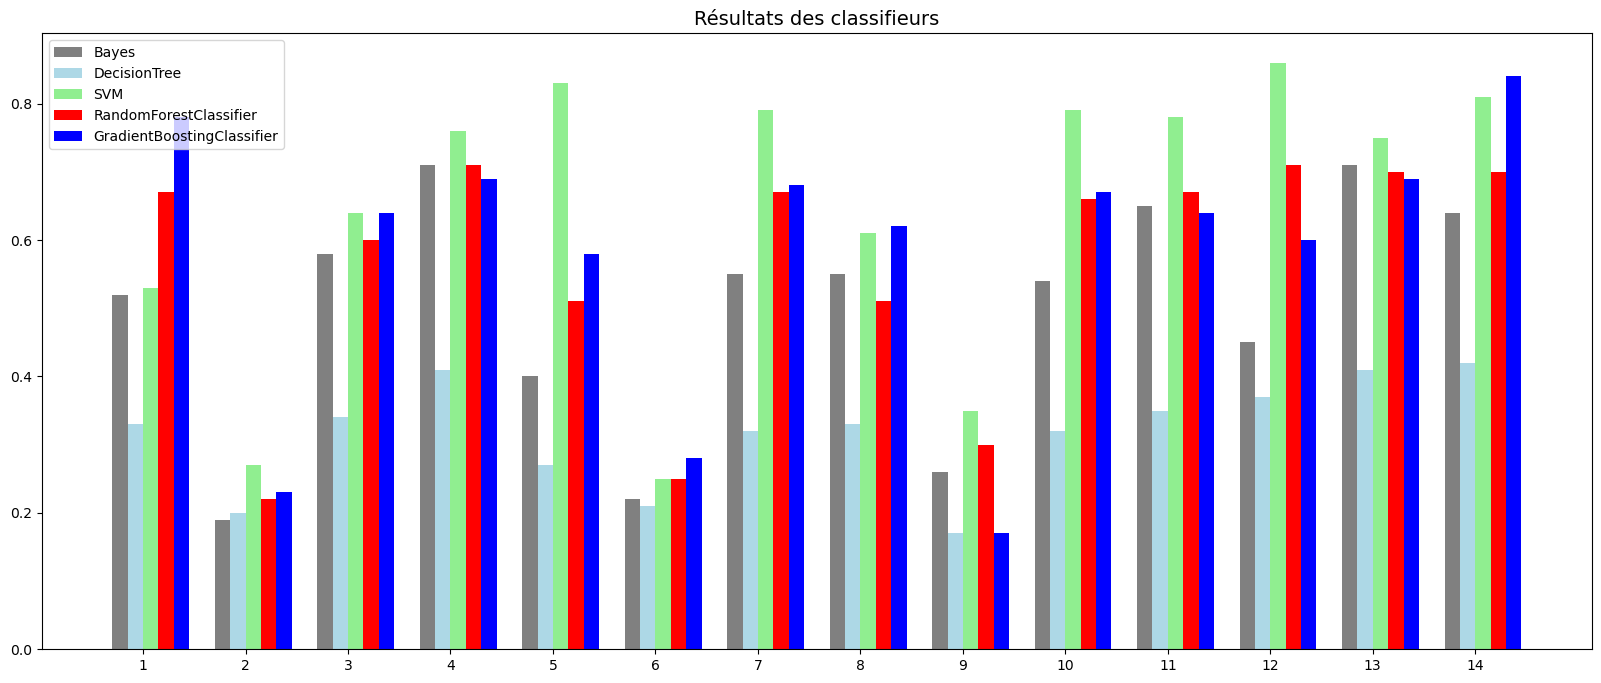

In [358]:
# Import des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt

# Définition des données
fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(1, nb_iterations+1)
bar_width = 0.15

# Boucle pour chaque itération
for i in x:
    # Création des barres pour chaque modèle
    # Barre pour le modèle Bayes
    bar1 = ax.bar(i-(1.5*bar_width),
                 df_score.loc[df_score["iteration"] == i, "bayes"],
                 width=bar_width,
                 color="gray"
                )
    # Barre pour le modèle DecisionTree
    bar2 = ax.bar(i-bar_width/2,
                 df_score.loc[df_score["iteration"] == i, "tree"],
                 width=bar_width,
                 color="lightblue"
                )
    # Barre pour le modèle SVM
    bar3 = ax.bar(i+bar_width/2,
                 df_score.loc[df_score["iteration"] == i, "svm"],
                 width=bar_width,
                 color="lightgreen"
                )
    # Barre pour le modèle RandomForestClassifier
    bar4 = ax.bar(i+(1.5*bar_width),
                 df_score.loc[df_score["iteration"] == i, "rf"],
                 width=bar_width,
                 color="red"
                )
    # Barre pour le modèle GradientBoostingClassifier
    bar5 = ax.bar(i+(2.5*bar_width),
                 df_score.loc[df_score["iteration"] == i, "GBC"],
                 width=bar_width,
                 color="blue"
                )    

# Configuration de l'axe des x
ax.set_xticks(x)
ax.set_xticklabels(x)

# Légende des modèles
plt.legend(["Bayes", "DecisionTree", "SVM", "RandomForestClassifier", "GradientBoostingClassifier"], loc="upper left")

# Titre du graphique
plt.title("Résultats des classifieurs", size=14)


In [361]:
y_test.unique()

array(['Kitchen & Dining ', 'Baby Care ', 'Home Furnishing ',
       'Home Decor & Festive Needs ', 'Watches ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [362]:
lst_cat = y_test.unique()

y_test.value_counts()

Baby Care                      42
Home Furnishing                40
Beauty and Personal Care       40
Watches                        39
Computers                      36
Kitchen & Dining               34
Home Decor & Festive Needs     32
Name: sous_cat_1, dtype: int64

L'échantillon de test contient : 263 articles.


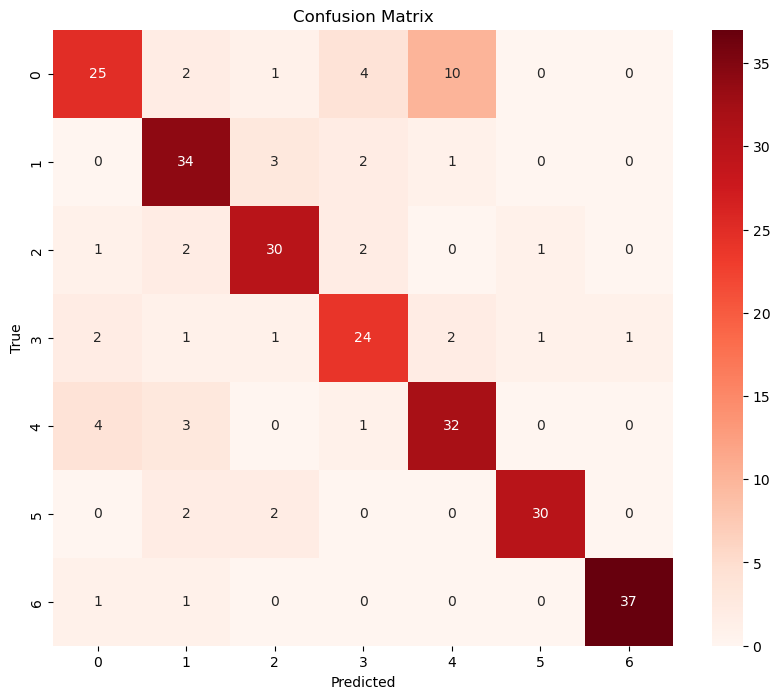

CPU times: total: 359 ms
Wall time: 364 ms


In [374]:
%%time

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

plt.figure(figsize=(10, 8))

print("L'échantillon de test contient :", X_test.shape[0], "articles.")

# Using seaborn to plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


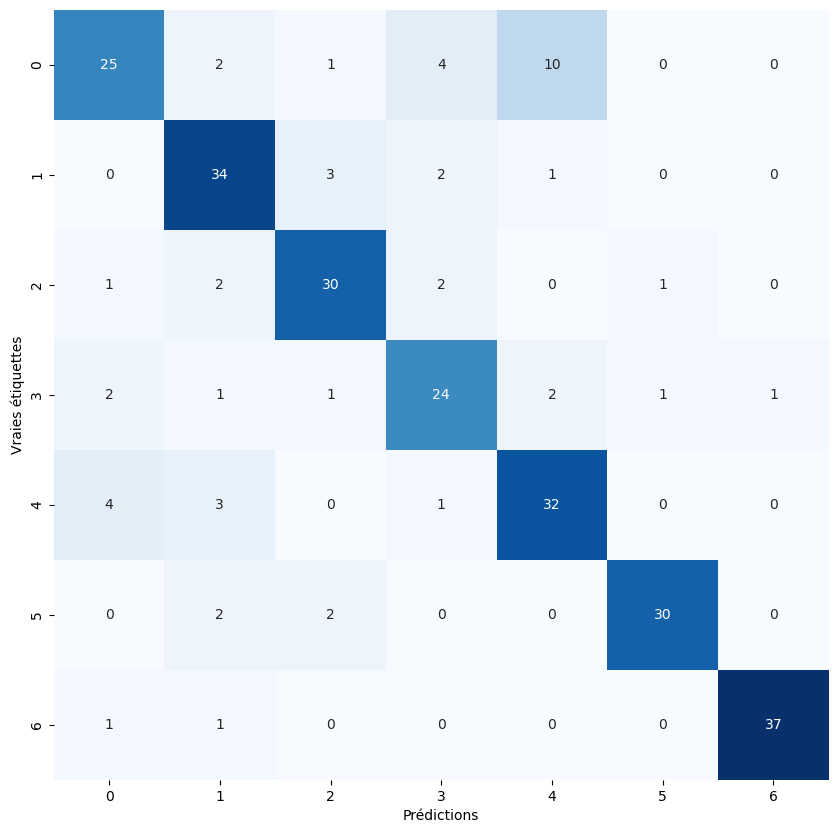

In [370]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Créez la matrice de confusion
cm = confusion_matrix(y_test, svm_predictions)

# Affichez la matrice de confusion sous forme de heatmap avec Seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.show()


# Clustering

### K-means

Nous allons rechercher la meilleure itération pour le K-means

In [375]:
def kmeans(mydata):

    #Cette fonction permet de calculer le nombre de clusters le plus optimal pour notre analyse : le coefficient de silhouette

    silhouette = []
    dispersion = []

    result_clusters = []
    result_ninit = []
    result_type_init = []

    df_iter_kmeans = pd.DataFrame()

    n_clusters = range(5,10)
    nbr_init = [10,30,50,70]
    type_init = ["k-means++", "random"]

    #Nous allons tester le modèle entre 2 et 15 clusters
    for num_clusters in n_clusters:

        for init in nbr_init:

            for i in type_init:

                #On configure l'algorithme
                cls = MiniBatchKMeans(n_clusters=num_clusters, 
                                     n_init=init, 
                                     init=i,
                                     random_state=0
                                    )

                #On l'entraîne sur les données préparées
                cls.fit(mydata)

                #On enregistre les scores de coefficient de silhouette à chaque passage
                silh = metrics.silhouette_score(mydata, cls.labels_)
                disp = cls.inertia_

                silhouette.append(silh)
                dispersion.append(disp)
                result_clusters.append(num_clusters)
                result_ninit.append(init)
                result_type_init.append(i)

    df_iter_kmeans["coef_silh"] = silhouette
    df_iter_kmeans["dispersion"] = dispersion
    df_iter_kmeans["nbr_clusters"] = result_clusters
    df_iter_kmeans["n_init"] = result_ninit
    df_iter_kmeans["type_init"] = result_type_init
    
    return df_iter_kmeans

In [376]:
def recherche_best_iter(mydata):

    #On affiche les paramètres de la meilleure itération
    best_iter = mydata.where(mydata["coef_silh"] == mydata["coef_silh"].max())
    best_iter.dropna(how="any", inplace=True)
    
    #On traite le cas où il y a plusieurs solutions possibles
    if best_iter.shape[0] > 0:
        best_iter = best_iter.iloc[0, :]
        
    # print(best_iter)

    return best_iter

In [377]:
def best_kmeans(mydata, best, cat_true):
    
    #On fait retourner le K-means avec la meilleure itération vue précédemment
    #Nous forçons le nombre de lusters à 7
    nbr_clusters = 7  # int(best["nbr_clusters"])
    ninit = int(best["n_init"])
    type_init = best["type_init"]

    cls_kmeans = MiniBatchKMeans(n_clusters=nbr_clusters, 
                                     n_init=ninit, 
                                     init=type_init,
                                     random_state=0
                                    )

    #On l'entraîne sur les données préparées
    cls_kmeans.fit(mydata)

    df_kmeans = pd.DataFrame()
    df_kmeans["labels"] = cls_kmeans.labels_
    df_kmeans["nbr_individus"] = 0
    df_kmeans = df_kmeans.groupby("labels", as_index=False).count()
    
    silh = round(metrics.silhouette_score(mydata, cls_kmeans.labels_), 2)
    ari = round(metrics.adjusted_rand_score(cat_true, cls_kmeans.labels_), 2)
    
    print("Coef silhouette :", silh)
    print("Score Adjusted Rand index :", ari)
    return cls_kmeans.labels_, df_kmeans, silh, ari;

In [378]:
def results_iterations_kmeans(mydata):

    #On affiche les scores

    df_coef_silh = mydata.groupby("nbr_clusters", as_index=False)["coef_silh"].max()
    df_dispersion = mydata.groupby("nbr_clusters", as_index=False)["dispersion"].min()

    plt.subplots(figsize=(25,10))

    plt.subplot(1,2,1)

    plt.plot(df_coef_silh["nbr_clusters"], df_coef_silh["coef_silh"], marker="o")
    plt.xlabel("Nbr de clusters", size=14)
    plt.ylabel("Coefficient de silhouette", size=14)
    plt.title("Variation coefficient de silhouette", size=14)
    plt.grid()

    plt.subplot(1,2,2)

    plt.plot(df_dispersion["nbr_clusters"], df_dispersion["dispersion"], marker="o")
    plt.xlabel("Nbr de clusters", size=14)
    plt.ylabel("Compacité clusters", size=14)
    plt.title("Variation de la compacité des clusters", size=14)
    plt.grid()


In [379]:
def homogeneite_clusters(mydata):

    print(mydata)
    plt.figure(figsize=(10,10))

    plt.bar(mydata["labels"], height=mydata["nbr_individus"])
    plt.xlabel("Nbr de clusters", size=14)
    plt.ylabel("Nbr individus", size=14)
    plt.title("Classement des individus", size=14)

In [380]:
# def affich_tsne(mydata):
                
#     time_start= time.time()

#     tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    
#     tsne_results = tsne.fit_transform(mydata)
    
#     print("TSNE terminée. Temps écoulé {} seconds.".format(time.time() - time_start))

#     df_results = pd.DataFrame(tsne_results, columns=["tsne_2d_one", "tsne_2d_two"])
    
#     #df_results["labels"] = labels #cls_kmeans.labels_
        
#     plt.figure(figsize=(25,12))
    
#     sns.scatterplot(
#         x=df_results["tsne_2d_one"],
#         y=df_results["tsne_2d_two"],
#         hue=mydata["labels"],
#         palette=sns.color_palette("hls", n_colors = len(mydata["labels"].unique())),
#         data=df_results,
#         legend="full",
#         #alpha=0.3
#     )
    

In [381]:
%%time
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

import time

lst_iterations = [df_iter_texte,
                  df_word2vec,
                  df_iter_bovw,
                  df_iter_vgg16,
                  df_iter_resnet50,
                  df_iter1_nmf,
                  df_iter2_nmf,
                  df_iter3_pca,
                  df_iter4_pca,
                  df_iter5,
                  df_iter6_nmf,
                  df_iter7
                 ]

lst_desc_iter = ["txt-tfidf",
                "txt_word2vec",
                "img_bovw",
                "img_vgg16",
                "img_resnet50",
                "nmf : txt_tfidf | img_bovw",
                "nmf : txt_tfidf | img_VGG16",
                "pca : txt_word2vec | img_bovw",
                "pca : txt_word2vec | img_VGG16",
                "txt_word2vec | img_VGG16_nmf",
                "nmf : txt_tfidf | img_ResNet50",
                "txt_word2vec | img_ResNet50_nmf"
                ]

le = LabelEncoder()
df_train["cat_encodee"] = le.fit_transform(df_train["sous_cat_1"])

# On va lancer l'algorithme pour chaque itération
# puis comparer leur scores : Coeff silhouette + ARI
# en les enregistrant dans un nouveau dataframe

df_scores = pd.DataFrame(columns=["iteration", "silhouette", "ari"], index=range(0, len(lst_iterations)))

j = 0

for i in lst_iterations:

    print("---------------------------------------------")
    print("Traitement de l'itération :", lst_desc_iter[j])
    
    #On fait un gridsearch sur le kmeans
    print("Recherche meilleur paramétrage sur GridSearch")
    df_iter_kmeans = kmeans(i)

    #Affichage des résultats des itérations
    #results_iterations_kmeans(df_iter_kmeans)

    #On recherche la meilleure itération
    print("Sélection meilleure itération")
    df_best_kmeans = recherche_best_iter(df_iter_kmeans)

    #On refait tourner l'algorithme du Kmeans avec la meilleure itération
    print("Kmeans en cours avec les meilleurs hyperparamètres et un nombre de clusters = 7")
    kmeans_labels, results, silhouette, ari = best_kmeans(i, df_best_kmeans, df_train["cat_encodee"])
    
    i["labels"] = kmeans_labels
    df_results_kmeans = results
    
    df_scores["iteration"][j] = lst_desc_iter[j]
    df_scores["silhouette"][j] = silhouette
    df_scores["ari"][j] = ari

    j += 1


---------------------------------------------
Traitement de l'itération : txt-tfidf
Recherche meilleur paramétrage sur GridSearch
Sélection meilleure itération
Kmeans en cours avec les meilleurs hyperparamètres et un nombre de clusters = 7
Coef silhouette : 0.52
Score Adjusted Rand index : 0.14
---------------------------------------------
Traitement de l'itération : txt_word2vec
Recherche meilleur paramétrage sur GridSearch
Sélection meilleure itération
Kmeans en cours avec les meilleurs hyperparamètres et un nombre de clusters = 7
Coef silhouette : 0.34
Score Adjusted Rand index : 0.19
---------------------------------------------
Traitement de l'itération : img_bovw
Recherche meilleur paramétrage sur GridSearch
Sélection meilleure itération
Kmeans en cours avec les meilleurs hyperparamètres et un nombre de clusters = 7
Coef silhouette : 0.28
Score Adjusted Rand index : 0.02
---------------------------------------------
Traitement de l'itération : img_vgg16
Recherche meilleur paramét

# Analyse des résultats

Une fois que toutes nos itérations ont été clusterisées, nous allons étudier les résultats :
 1. Synthèse des scores :
     - Classement des coefficients de silhouette
     - Classement des ARI
     - Choix de la meilleure itération sur l'ARI
     
 2. Etude de la meilleure itération :
     - Analyse TSNE
     - Analyse homogénéïté des clusters
     - Comparaison des clusters en fonction des catégories de départ. Avec une matrice de confusion.

### Etude globale et synthèse

In [382]:
df_scores

,iteration,silhouette,ari
0,txt-tfidf,0.52,0.14
1,txt_word2vec,0.34,0.19
2,img_bovw,0.28,0.02
3,img_vgg16,0.37,0.19
4,img_resnet50,0.42,0.31
5,nmf : txt_tfidf | img_bovw,0.21,0.02
6,nmf : txt_tfidf | img_VGG16,0.62,0.11
7,pca : txt_word2vec | img_bovw,0.06,0.02
8,pca : txt_word2vec | img_VGG16,0.07,0.09
9,txt_word2vec | img_VGG16_nmf,0.35,0.14


Text(0.5, 1.0, 'Comparaison coefficients de silhouette')

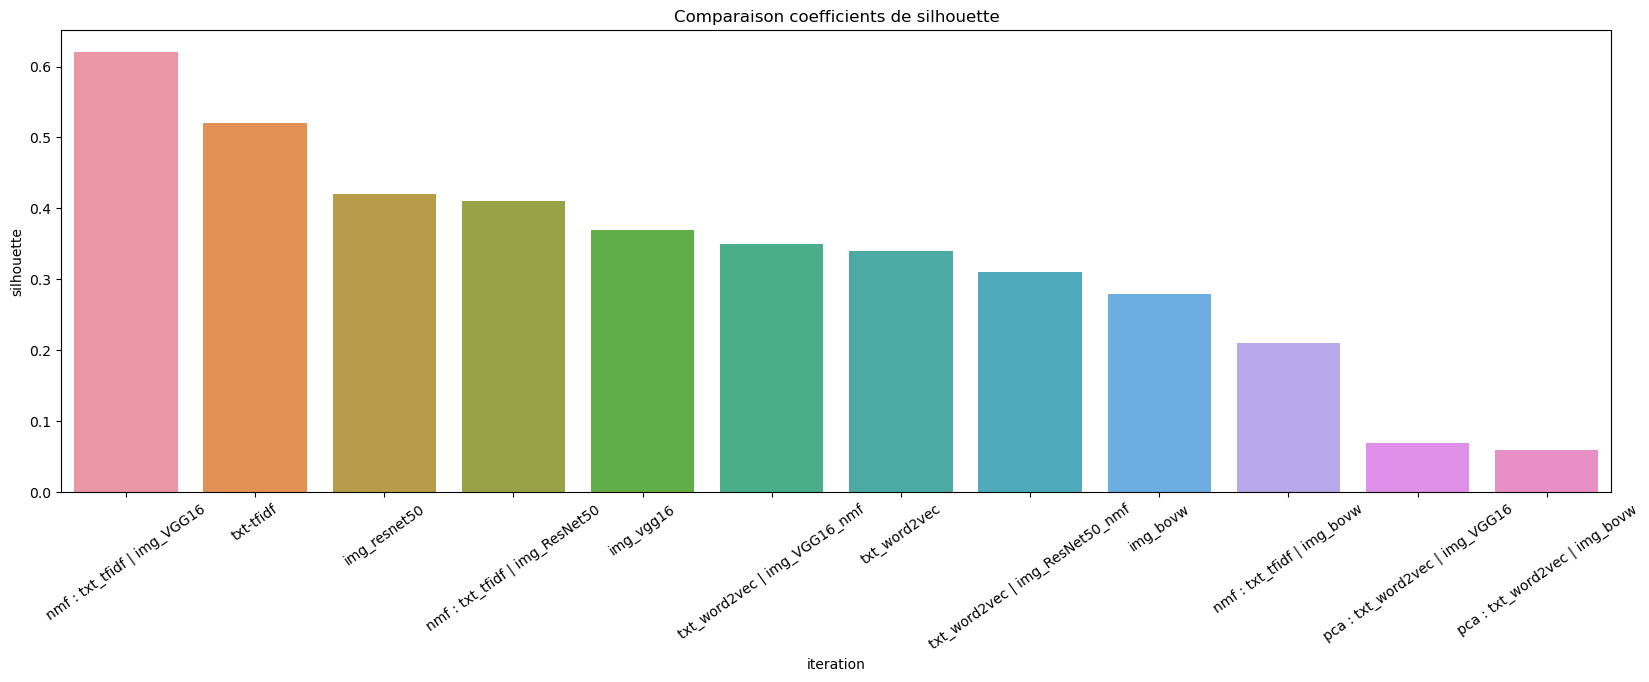

In [383]:

data = df_scores.sort_values(by="silhouette", ascending=False)
plt.figure(figsize=(20, 6))
plt.xticks(rotation=35)
sns.barplot(x=data["iteration"], y=data["silhouette"])
plt.title("Comparaison coefficients de silhouette", size=12)

Text(0.5, 1.0, 'Comparaison des Adjusted Rand Index')

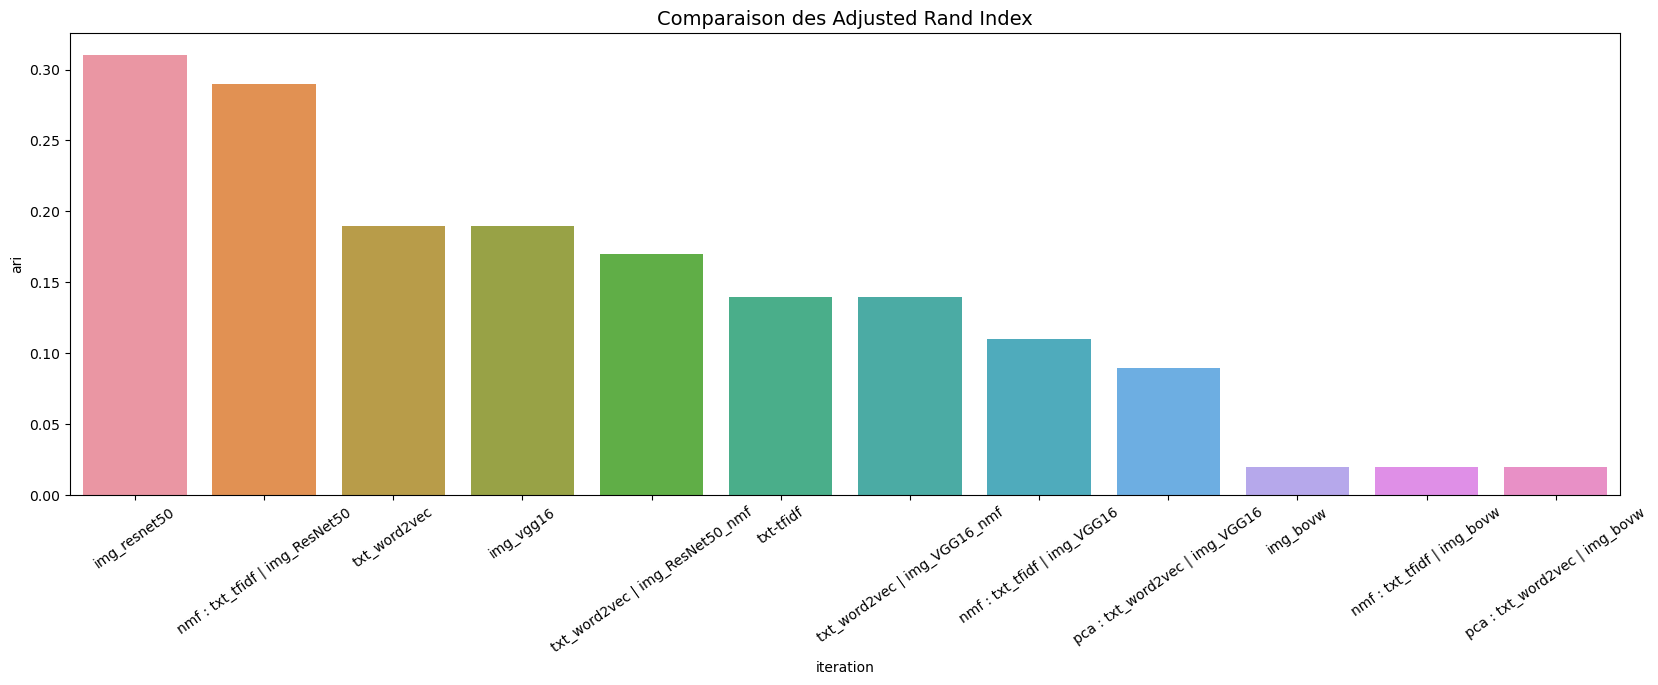

In [385]:
data = df_scores.sort_values(by="ari", ascending=False)
plt.figure(figsize=(20, 6))
plt.xticks(rotation=35)
sns.barplot(x=data["iteration"], y=data["ari"])
plt.title("Comparaison des Adjusted Rand Index", size=14)

### Etude meilleure itération

#### TSNE

In [391]:
df_iter6_nmf

,0,1,2,3,4,5,6,labels
0,7.516059e-02,4.358139e-03,9.488087e-01,0.681834,6.036394e-04,1.260794e-07,1.205321e-01,1
1,2.893480e-02,1.889128e-15,9.823526e-02,0.699285,4.422195e-12,3.645082e-01,1.611769e+00,0
2,2.943758e-07,4.601541e-15,7.517537e-03,1.932281,1.206985e-05,1.162461e-02,4.603755e-01,1
3,1.226697e-04,6.166205e-08,2.558243e-08,1.269966,7.336987e-03,5.534088e-02,5.705261e-01,1
4,7.153722e-02,5.901740e-04,3.318298e-10,1.422791,2.814798e-02,2.983010e-01,4.471772e-01,1
...,...,...,...,...,...,...,...,...
1045,1.383027e-02,3.034187e-13,1.616497e-06,0.881551,1.511062e-01,7.955313e-02,3.082260e-01,1
1046,1.904104e+00,7.270910e-06,4.773703e-02,0.607885,4.127221e-02,1.745327e-13,6.402726e-08,5
1047,4.033838e-01,4.804692e-07,3.099574e-05,0.817209,2.194507e-01,1.610880e-01,6.922833e-01,1
1048,2.103607e+00,4.956562e-03,6.112274e-03,0.632962,8.425486e-03,7.856426e-12,2.994737e-06,5


In [397]:
def affich_tsne(mydata):
    time_start = time.time()
    # 2. Séparez les caractéristiques (colonnes 0 à 6) des étiquettes (colonne "labels") dans votre DataFrame :

    X = mydata.iloc[:, :-1]  # Caractéristiques
    y = mydata["labels"]  # Étiquettes

# 3. Appliquez t-SNE pour réduire les dimensions :

#     tsne = TSNE(n_components=2, perplexity=30, random_state=42)
#     X_tsne = tsne.fit_transform(X)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    
    mydata = mydata.astype(str)  # Convertir toutes les données en chaînes de caractères
    
    tsne_results = tsne.fit_transform(X)
    
    print("TSNE terminée. Temps écoulé {} seconds.".format(time.time() - time_start))

    df_results = pd.DataFrame(tsne_results, columns=["tsne_2d_one", "tsne_2d_two"])
    
    plt.figure(figsize=(25, 12))
    
    sns.scatterplot(
        x=df_results["tsne_2d_one"],
        y=df_results["tsne_2d_two"],
        hue=mydata["labels"],
        palette=sns.color_palette("hls", n_colors=len(mydata["labels"].unique())),
        data=df_results,
        legend="full",
    )


TSNE - Kmeans
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.002s...
[t-SNE] Computed neighbors for 1050 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 0.319679
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.243351
[t-SNE] KL divergence after 300 iterations: 0.762134
TSNE terminée. Temps écoulé 1.751866102218628 seconds.


<Figure size 2000x600 with 0 Axes>

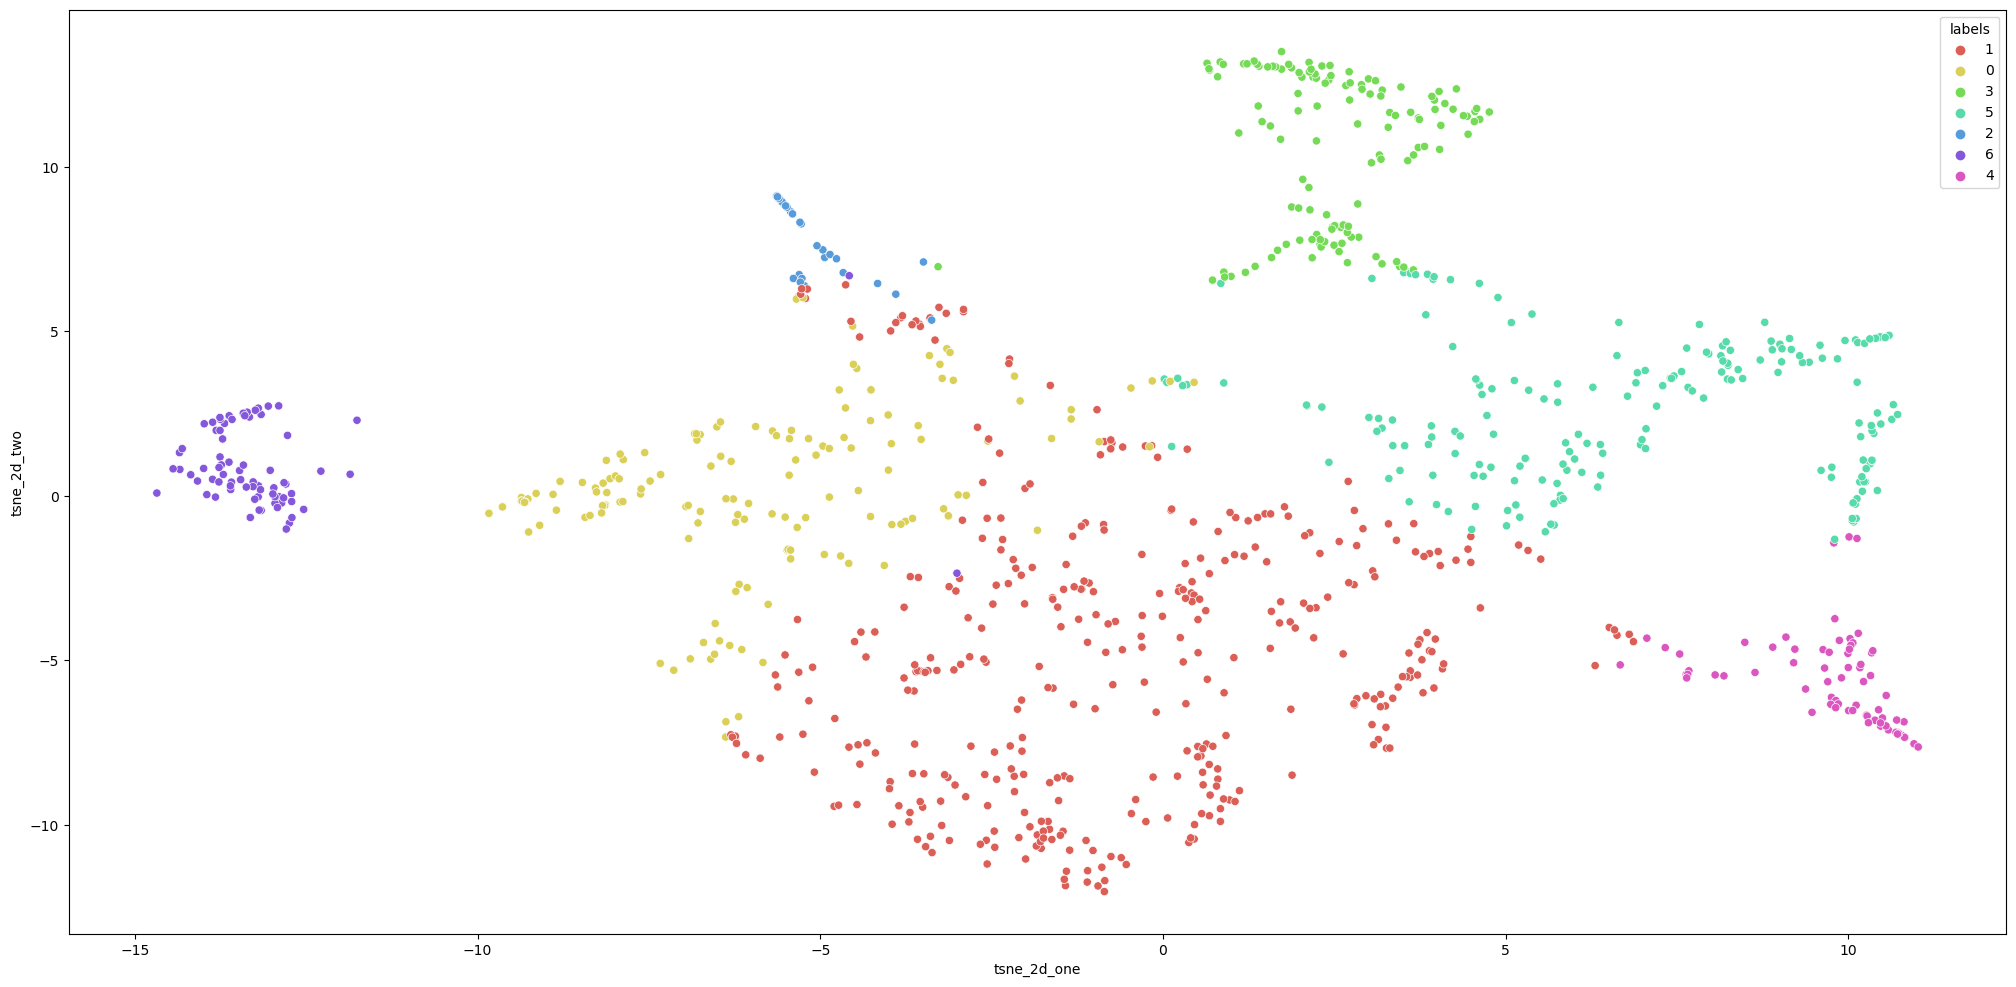

In [399]:

# On affiche l'aspect de l'homogénéité des clusters
# print("Homogénéité clusters")
# homogeneite_clusters(df_results_kmeans)

# On affiche la TSNE
print("TSNE - Kmeans")
plt.figure(figsize=(20,6))
affich_tsne(df_iter6_nmf)

In [394]:
# def affich_tsne(mydata):
                
#     time_start= time.time()

#     tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    
#     tsne_results = tsne.fit_transform(mydata)
    
#     print("TSNE terminée. Temps écoulé {} seconds.".format(time.time() - time_start))

#     df_results = pd.DataFrame(tsne_results, columns=["tsne_2d_one", "tsne_2d_two"])
    
#     #df_results["labels"] = labels #cls_kmeans.labels_
        
#     plt.figure(figsize=(25,12))
    
#     sns.scatterplot(
#         x=df_results["tsne_2d_one"],
#         y=df_results["tsne_2d_two"],
#         hue=mydata["labels"],
#         palette=sns.color_palette("hls", n_colors = len(mydata["labels"].unique())),
#         data=df_results,
#         legend="full",
#         #alpha=0.3
#     )

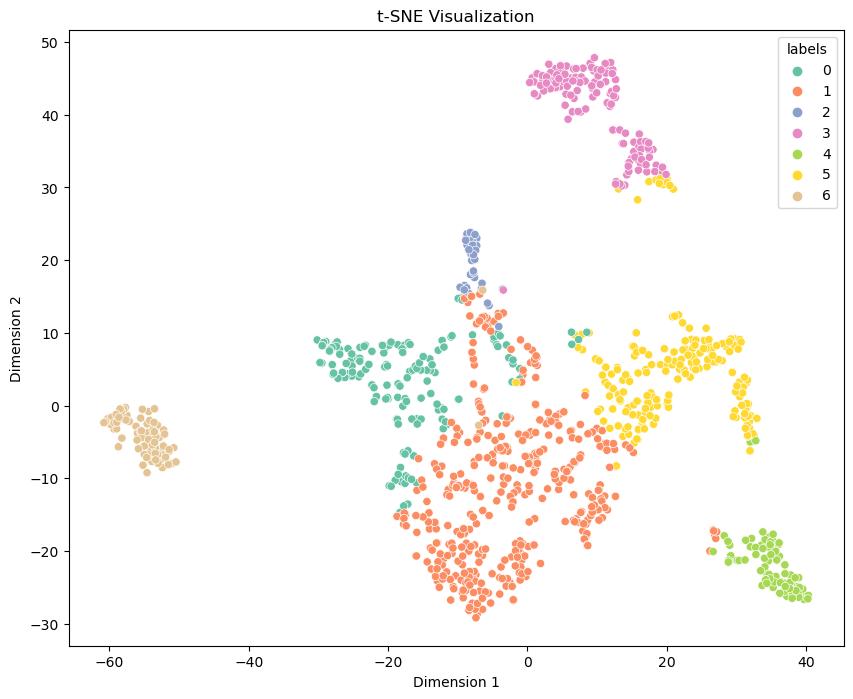

In [406]:
# 1. Importez les bibliothèques nécessaires :

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 2. Séparez les caractéristiques (colonnes 0 à 6) des étiquettes (colonne "labels") dans votre DataFrame :

X = df_iter6_nmf.iloc[:, :-1]  # Caractéristiques
y = df_iter6_nmf["labels"]  # Étiquettes

# 3. Appliquez t-SNE pour réduire les dimensions :

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# - `n_components` définit le nombre de dimensions souhaité après la réduction. Ici, nous utilisons 2 pour obtenir une représentation en 2D.
# - `perplexity` est un paramètre qui peut être ajusté pour influencer la réduction, il détermine l'équilibre entre les zones denses et les zones étendues dans la projection. Vous pouvez ajuster sa valeur en fonction de votre besoin.

# 4. Créez un nouveau DataFrame avec les coordonnées t-SNE et les étiquettes :

tsne_df = pd.DataFrame(data={"Dimension 1": X_tsne[:, 0], "Dimension 2": X_tsne[:, 1], "labels": y})

# 5. Visualisez les données réduites avec t-SNE en utilisant Matplotlib :

plt.figure(figsize=(10, 8))
sns.scatterplot(x="Dimension 1", y="Dimension 2", hue="labels", data=tsne_df, palette="Set2")
plt.title("t-SNE Visualization")
plt.show()


#### Homogénéïté clusters

In [407]:
df_nb_individus = pd.DataFrame(df_iter6_nmf["labels"].value_counts(), columns=["labels", "nbr_individus"])
df_nb_individus["nbr_individus"] = df_nb_individus["labels"]
df_nb_individus.drop("labels", axis=1, inplace=True)
df_nb_individus.reset_index(inplace=True)
df_nb_individus = df_nb_individus.rename(columns={"index": "labels"})
df_nb_individus

,labels,nbr_individus
0,1,377
1,5,194
2,0,162
3,3,128
4,4,78
5,6,75
6,2,36


Homogénéité clusters
   labels  nbr_individus
0       1            377
1       5            194
2       0            162
3       3            128
4       4             78
5       6             75
6       2             36


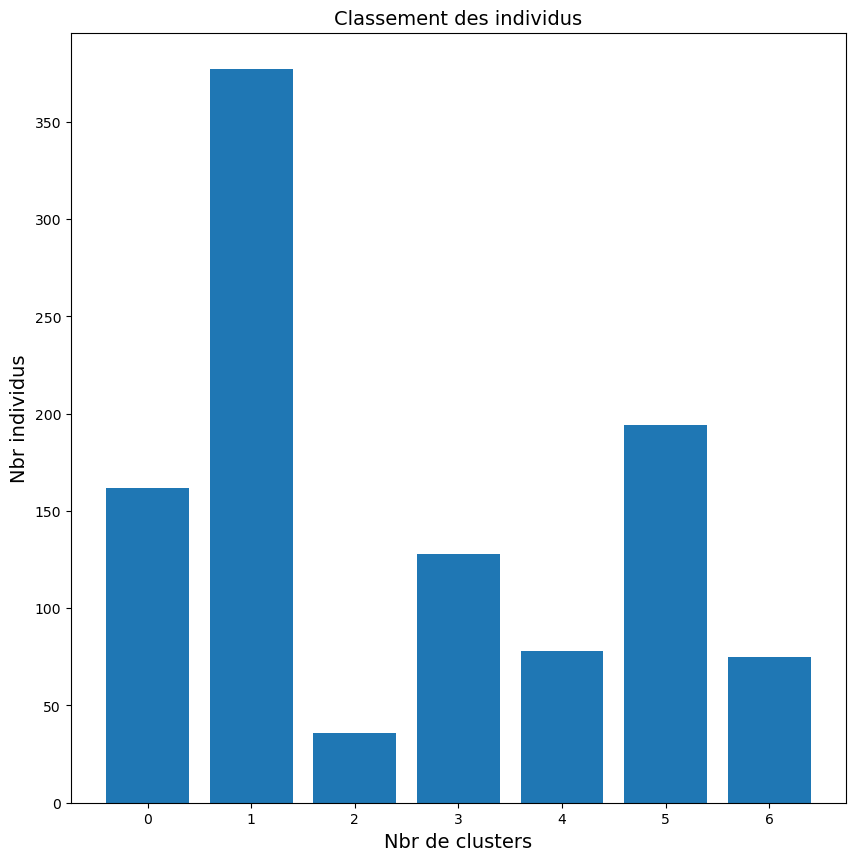

In [408]:
# On affiche l'aspect de l'homogénéité des clusters
print("Homogénéité clusters")
homogeneite_clusters(df_nb_individus)


In [410]:
df_tri_cat["sous_cat_1"].unique()

array([' Care ', ' Decor & Festive Needs ', ' Furnishing ',
       'hen & Dining ', 'hes ', 'ty and Personal Care ', 'uters '],
      dtype=object)

In [434]:
data_t = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")

df_tri_cat_t = data_t.loc[:, ["description", "product_category_tree"]]

# On crée une liste de strings en supprimant les >>
df1 = df_tri_cat_t["product_category_tree"].str.split(">>")

# Et on ne récupère que la deuxième valeur de la liste
# Ce qui correspondra à notre catégorie de produits
df_tri_cat["sous_cat_1"] = df1.apply(lambda x: x[0])
# df_train["sous_cat_2"] = df.apply(lambda x: x[1])

In [489]:
df_tri_cat.head(1)

,description,product_category_tree,sous_cat_1,sous_cat_2,tf_idf,word2vec,image,image_grayscale,image_redim,image_redim_contrast,bovw,VGG16,resnet50,cat_encodee
1049,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...","[""Baby Care",Baby & Kids Gifts,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.08955493, 0.12389432, -0.016749272, 0.2335...",data/Images/f2f027ad6a6df617c9f125173da71e44.jpg,data/Images/Images_grayscale/f2f027ad6a6df617c...,data/Images/Images_redim/f2f027ad6a6df617c9f12...,data/Images/Images_redim_contrast/f2f027ad6a6d...,"[3.0, 0.0, 1.0, 1.0, 2.0, 0.0, 9.0, 0.0, 3.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [435]:
df_tri_cat["sous_cat_1"].unique()

array(['["Baby Care ', '["Home Decor & Festive Needs ',
       '["Home Furnishing ', '["Kitchen & Dining ', '["Watches ',
       '["Beauty and Personal Care ', '["Computers '], dtype=object)

#### Matrice de confusion

Text(0.5, 80.7222222222222, 'Clusters')

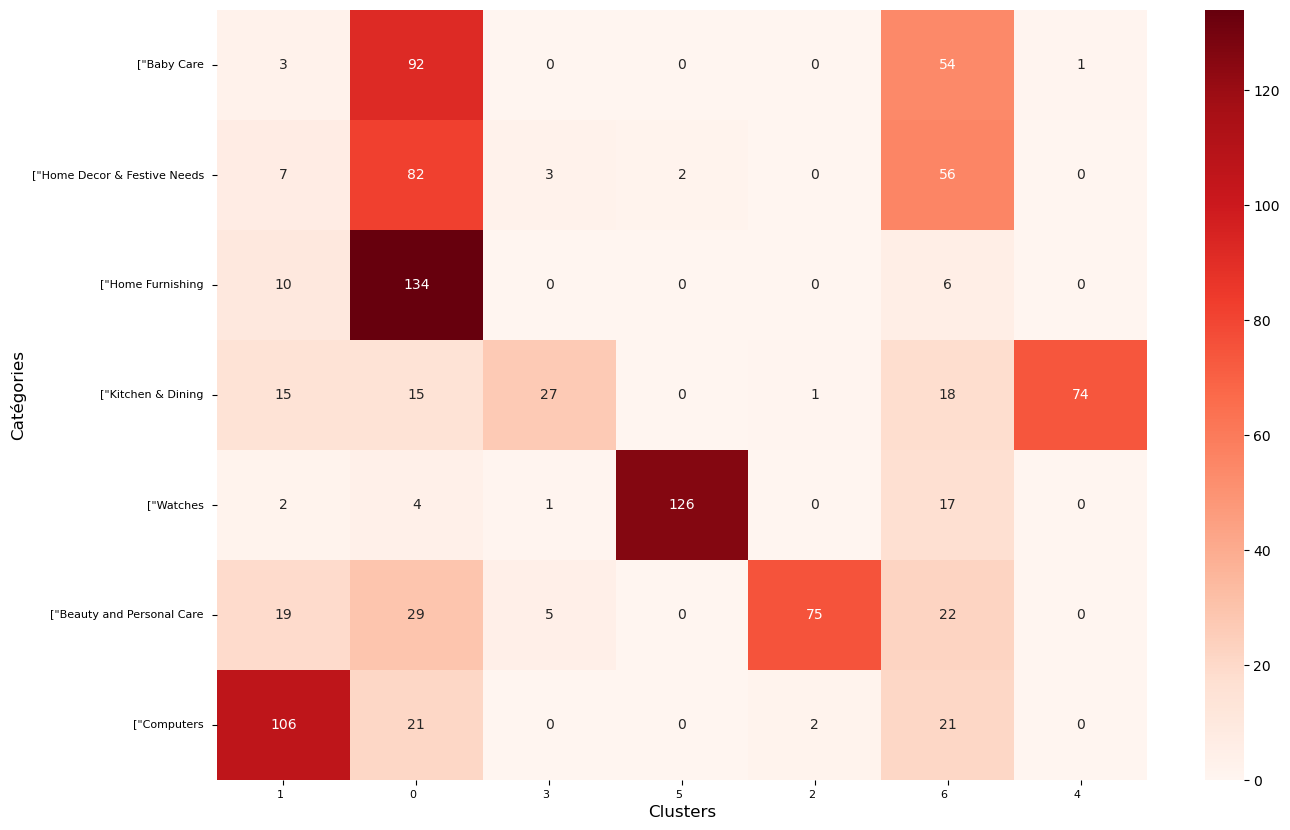

In [437]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df_train["cat_encodee"], df_iter6_nmf["labels"])

# df_tri_cat = df_train.sort_values()

df_cm = pd.DataFrame(cm, 
                     index=df_tri_cat["sous_cat_1"].unique(), 
                     columns=df_iter6_nmf["labels"].unique()
                    )

fig = plt.figure(figsize=(15,10))

try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Reds")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
    
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=8)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=8)
plt.ylabel("Catégories", size=12)
plt.xlabel("Clusters", size=12)

In [490]:
# param_dist = {'C': [0.001, 0.01, 0.1, 1, 10]}
# random_search = RandomizedSearchCV(LogisticRegression(),
#                             param_distributions=param_dist,
#                             cv=10)

# df_train_vect = df_iter6_nmf.drop("labels", axis=1)
# df_target = df_iter6_nmf["labels"]
# rand_search_iter6 = random_search.fit(df_iter6_nmf, des_target)

# print("Mean Random Search accuracy:", rand_search_iter6.best_score_)

In [441]:
from sklearn.neighbors import KNeighborsClassifier

df_train_vect = df_iter6_nmf.drop("labels", axis=1)
df_target = df_iter6_nmf["labels"]

#create new a knn model
knn = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 11)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=10)

#fit model to data
knn_gscv.fit(df_train_vect, df_target)
    
#check top performing n_neighbors value
print("La meilleure accuracy est",
      knn_gscv.score(df_train_vect, df_target),
      "avec",
      knn_gscv.best_params_,
      "voisins.")

La meilleure accuracy est 0.98 avec {'n_neighbors': 8} voisins.


In [444]:
from sklearn.model_selection import GridSearchCV

# Créez le modèle (par exemple, DecisionTreeClassifier)
model = DecisionTreeClassifier()

# Définissez la grille des hyperparamètres à rechercher
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Utilisez GridSearchCV pour la recherche exhaustive
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search.fit(df_train_vect, df_target)

# Affichez les résultats
print("Meilleure accuracy :", grid_search.best_score_)
print("Meilleurs hyperparamètres :", grid_search.best_params_)


Meilleure accuracy : 0.9514285714285714
Meilleurs hyperparamètres : {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [453]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Créez le modèle (par exemple, RandomForestClassifier)
model = RandomForestClassifier()

# Définissez la grille des hyperparamètres à rechercher (ici, n_estimators et max_depth)
param_dist = {
    'n_estimators': randint(1, 100),
    'max_depth': randint(1, 20)
}

# Utilisez RandomizedSearchCV pour la recherche aléatoire
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5)
random_search.fit(df_train_vect, df_target)

# Affichez les résultats
print("Meilleure accuracy :", random_search.best_score_)
print("Meilleurs hyperparamètres :", random_search.best_params_)


Meilleure accuracy : 0.9647619047619049
Meilleurs hyperparamètres : {'max_depth': 14, 'n_estimators': 74}


In [452]:
# !pip install scikit-optimize


In [451]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# # Créez le modèle (par exemple, RandomForestClassifier)
# model = RandomForestClassifier()

# # Définissez l'espace des hyperparamètres à rechercher
# param_dist = {
#     'n_estimators': Integer(1, 100),
#     'max_depth': Integer(1, 20),
#     'min_samples_split': Real(0.1, 1.0),
#     'min_samples_leaf': Real(0.1, 0.5),
#     'criterion': Categorical(['gini', 'entropy'])
# }

# # Utilisez BayesSearchCV pour la recherche bayésienne
# bayes_search = BayesSearchCV(
#     model,
#     search_spaces=param_dist,
#     n_iter=10,  # Nombre d'itérations pour la recherche
#     cv=5
# )

# bayes_search.fit(df_train_vect, df_target)

# # Affichez les résultats
# print("Meilleure accuracy :", bayes_search.best_score_)
# print("Meilleurs hyperparamètres :", bayes_search.best_params_)


In [511]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Conv3D, GlobalAveragePooling2D, Dense
from keras.applications import VGG16
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling3D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling3D, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def compare_methods(df):
    # Séparation des caractéristiques (X) et de la cible (y)
    X = df.drop("cat_encodee", axis=1)
    # Sélectionnez uniquement les colonnes numériques


    y = df["cat_encodee"]
    # Traitement des données textuelles avec TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
    X_tfidf = tfidf_vectorizer.fit_transform(df["description"])
    X = X.select_dtypes(include=[np.number])
    # Ajoutez les caractéristiques TF-IDF aux caractéristiques existantes
    X = np.hstack((X.values, X_tfidf.toarray()))
    
#     # Division des données en ensembles d'entraînement et de test
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Méthode 1 : Random Forest
    start_time = time.time()
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    rf_pred = rf_classifier.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_time = time.time() - start_time
    
    # Méthode 2 : SVM avec PCA
    start_time = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    pca = PCA(n_components=50)  # Réduction de dimension
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    svm_classifier = SVC(kernel='linear', C=1, random_state=42)
    svm_classifier.fit(X_train_pca, y_train)
    svm_pred = svm_classifier.predict(X_test_pca)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_time = time.time() - start_time
    
    # Méthode 3 : Réseaux neuronaux récurrents à mémoire à long terme (LSTM)
    start_time = time.time()
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
#     X_train_lstm = X_train.values.reshape(-1, 1, X_train.shape[1])
#     X_test_lstm = X_test.values.reshape(-1, 1, X_test.shape[1])
    X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
    X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

    
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, input_shape=(1, X_train.shape[1])))
    lstm_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    lstm_model.fit(X_train_lstm, y_train_encoded, epochs=10, batch_size=64, verbose=0)
    lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_encoded, verbose=0)[1]
    lstm_time = time.time() - start_time
    
    # Méthode 4 : Réseaux neuronaux à convolution en 3D (3D CNN)
    start_time = time.time()
#     X_train_3d = X_train.values.reshape(-1, 10, 10, 10, 1)
#     X_test_3d = X_test.values.reshape(-1, 10, 10, 10, 1)
    X_train_3d = X_train.reshape(-1, 10, 10, 10, 1)
    X_test_3d = X_test.reshape(-1, 10, 10, 10, 1)

    
    cnn3d_model = Sequential()
    cnn3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(10, 10, 10, 1)))
    cnn3d_model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Ajoutez une couche de réduction de dimension
    cnn3d_model.add(GlobalAveragePooling3D())  # Couche GlobalAveragePooling3D
    cnn3d_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    cnn3d_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
#     cnn3d_model = Sequential()
#     cnn3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(10, 10, 10, 1)))
#     cnn3d_model.add(GlobalAveragePooling2D())
#     cnn3d_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
#     cnn3d_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cnn3d_model.fit(X_train_3d, y_train_encoded, epochs=10, batch_size=64, verbose=0)
    cnn3d_accuracy = cnn3d_model.evaluate(X_test_3d, y_test_encoded, verbose=0)[1]
    cnn3d_time = time.time() - start_time
    
#     # Méthode 5 : Réseaux de neurones pré-entraînés (Transfer Learning)
#     print("img_path : " , img_path)
#     start_time = time.time()
#     base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     X_train_transfer = np.array([image.img_to_array(image.load_img(img_path, target_size=(224, 224))) for img_path in X_train["image"]])
#     X_test_transfer = np.array([image.img_to_array(image.load_img(img_path, target_size=(224, 224))) for img_path in X_test["image"]])
#     X_train_transfer = base_model.predict(X_train_transfer)
#     X_test_transfer = base_model.predict(X_test_transfer)
    
#     model = Sequential()
#     model.add(GlobalAveragePooling2D(input_shape=X_train_transfer.shape[1:]))
#     model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model.fit(X_train_transfer, y_train_encoded, epochs=10, batch_size=64, verbose=0)
#     transfer_accuracy = model.evaluate(X_test_transfer, y_test_encoded, verbose=0)[1]
#     transfer_time = time.time() - start_time

    transfer_accuracy = 0
    transfer_time = 0

    # Méthode 6 : Réseaux de neurones profonds (DNN)
    start_time = time.time()
    dnn_model = Sequential()
    dnn_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    dnn_model.add(Dense(64, activation='relu'))
    dnn_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    dnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    dnn_model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=64, verbose=0)
    dnn_accuracy = dnn_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)[1]
    dnn_time = time.time() - start_time
    
    # Créez un DataFrame pour stocker les résultats
    results = pd.DataFrame({
        'Méthode': ['Random Forest', 'SVM avec PCA', 'LSTM', '3D CNN', 'Transfer Learning', 'DNN'],
        'Précision': [rf_accuracy, svm_accuracy, lstm_accuracy, cnn3d_accuracy, transfer_accuracy, dnn_accuracy],
        'Temps (secondes)': [rf_time, svm_time, lstm_time, cnn3d_time, transfer_time, dnn_time]
    })
    
    return results

# Utilisation de la fonction avec votre dataframe
# df = ...  # Remplacez ceci par votre dataframe
comparison_results = compare_methods(df_tri_cat)
print(comparison_results)


             Méthode  Précision  Temps (secondes)
0      Random Forest   0.933333          0.797126
1       SVM avec PCA   0.885714          0.110473
2               LSTM   0.933333          4.740831
3             3D CNN   0.119048         16.866670
4  Transfer Learning   0.000000          0.000000
5                DNN   0.909524          1.264399


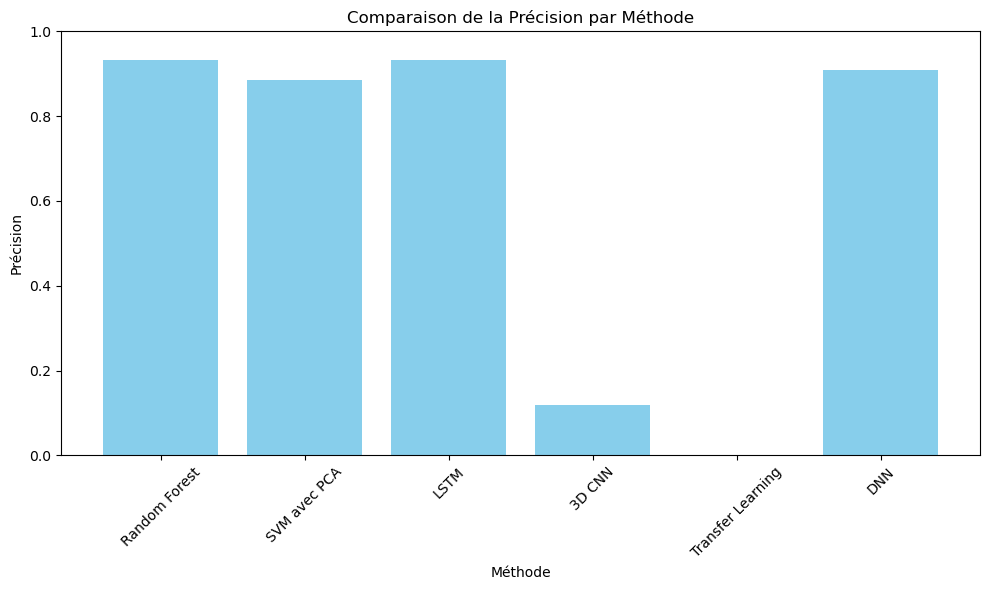

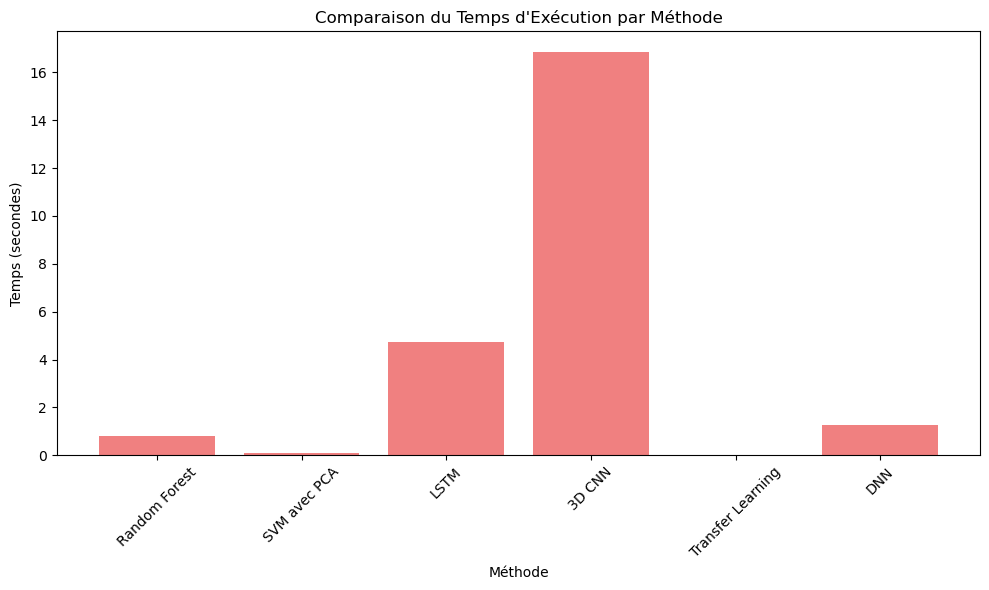

In [513]:
# 1. Graphique de comparaison de précision :

plt.figure(figsize=(10, 6))
plt.bar(comparison_results['Méthode'], comparison_results['Précision'], color='skyblue')
plt.title('Comparaison de la Précision par Méthode')
plt.xlabel('Méthode')
plt.ylabel('Précision')
plt.ylim(0, 1.0)  # Ajustez cette plage en fonction de vos données
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Graphique de comparaison de temps d'exécution :

plt.figure(figsize=(10, 6))
plt.bar(comparison_results['Méthode'], comparison_results['Temps (secondes)'], color='lightcoral')
plt.title('Comparaison du Temps d\'Exécution par Méthode')
plt.xlabel('Méthode')
plt.ylabel('Temps (secondes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [522]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Conv3D, GlobalAveragePooling2D, Dense
from keras.applications import VGG16
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling3D, MaxPooling1D, GlobalMaxPooling1D, GlobalMaxPooling3D, GlobalAveragePooling3D, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def compare_methods(df):
    # Séparation des caractéristiques (X) et de la cible (y)
    X = df.drop("cat_encodee", axis=1)
    # Sélectionnez uniquement les colonnes numériques


    y = df["cat_encodee"]
    # Traitement des données textuelles avec TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
    X_tfidf = tfidf_vectorizer.fit_transform(df["description"])
    X = X.select_dtypes(include=[np.number])
    # Ajoutez les caractéristiques TF-IDF aux caractéristiques existantes
    X = np.hstack((X.values, X_tfidf.toarray()))
    
#     # Division des données en ensembles d'entraînement et de test
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
    # Division des données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Méthode 1 : Random Forest
    start_time = time.time()
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)
    rf_pred = rf_classifier.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_time = time.time() - start_time
    
    # Méthode 2 : SVM avec PCA
    start_time = time.time()
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    pca = PCA(n_components=50)  # Réduction de dimension
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    svm_classifier = SVC(kernel='linear', C=1, random_state=42)
    svm_classifier.fit(X_train_pca, y_train)
    svm_pred = svm_classifier.predict(X_test_pca)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_time = time.time() - start_time
    
    # Méthode 3 : Réseaux neuronaux récurrents à mémoire à long terme (LSTM)
    start_time = time.time()
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
#     X_train_lstm = X_train.values.reshape(-1, 1, X_train.shape[1])
#     X_test_lstm = X_test.values.reshape(-1, 1, X_test.shape[1])
    X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
    X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

    
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, input_shape=(1, X_train.shape[1])))
    lstm_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    lstm_model.fit(X_train_lstm, y_train_encoded, epochs=10, batch_size=64, verbose=0)
    lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_encoded, verbose=0)[1]
    lstm_time = time.time() - start_time
    
    # Méthode 4 : Réseaux neuronaux à convolution en 3D (3D CNN)
    start_time = time.time()
#     X_train_3d = X_train.values.reshape(-1, 10, 10, 10, 1)
#     X_test_3d = X_test.values.reshape(-1, 10, 10, 10, 1)
    X_train_3d = X_train.reshape(-1, 10, 10, 10, 1)
    X_test_3d = X_test.reshape(-1, 10, 10, 10, 1)

    
    cnn3d_model = Sequential()
    cnn3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(10, 10, 10, 1)))
    cnn3d_model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Ajoutez une couche de réduction de dimension
    cnn3d_model.add(GlobalAveragePooling3D())  # Couche GlobalAveragePooling3D
    cnn3d_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    cnn3d_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
#     cnn3d_model = Sequential()
#     cnn3d_model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(10, 10, 10, 1)))
#     cnn3d_model.add(GlobalAveragePooling2D())
#     cnn3d_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
#     cnn3d_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cnn3d_model.fit(X_train_3d, y_train_encoded, epochs=10, batch_size=64, verbose=0)
    cnn3d_accuracy = cnn3d_model.evaluate(X_test_3d, y_test_encoded, verbose=0)[1]
    cnn3d_time = time.time() - start_time
    
#     # Méthode 5 : Réseaux de neurones pré-entraînés (Transfer Learning)
#     print("img_path : " , img_path)
#     start_time = time.time()
#     base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     X_train_transfer = np.array([image.img_to_array(image.load_img(img_path, target_size=(224, 224))) for img_path in X_train["image"]])
#     X_test_transfer = np.array([image.img_to_array(image.load_img(img_path, target_size=(224, 224))) for img_path in X_test["image"]])
#     X_train_transfer = base_model.predict(X_train_transfer)
#     X_test_transfer = base_model.predict(X_test_transfer)
    
#     model = Sequential()
#     model.add(GlobalAveragePooling2D(input_shape=X_train_transfer.shape[1:]))
#     model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model.fit(X_train_transfer, y_train_encoded, epochs=10, batch_size=64, verbose=0)
#     transfer_accuracy = model.evaluate(X_test_transfer, y_test_encoded, verbose=0)[1]
#     transfer_time = time.time() - start_time

    transfer_accuracy = 0
    transfer_time = 0

    # Méthode 6 : Réseaux de neurones profonds (DNN)
    start_time = time.time()
    dnn_model = Sequential()
    dnn_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    dnn_model.add(Dense(64, activation='relu'))
    dnn_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    dnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    dnn_model.fit(X_train_scaled, y_train_encoded, epochs=10, batch_size=64, verbose=0)
    dnn_accuracy = dnn_model.evaluate(X_test_scaled, y_test_encoded, verbose=0)[1]
    dnn_time = time.time() - start_time

    
    # Méthode 6 : Réseaux neuronaux récurrents à structure hiérarchique (HRNN)
    start_time = time.time()
    hrnn_model = Sequential()

#     hrnn_model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    hrnn_model.add(LSTM(100, return_sequences=True))
    hrnn_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    hrnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hrnn_model.fit(X_train_lstm, y_train_encoded, epochs=10, batch_size=64, verbose=0)
    hrnn_accuracy = hrnn_model.evaluate(X_test_lstm, y_test_encoded, verbose=0)[1]
    hrnn_time = time.time() - start_time

#     # Méthode 7 : Réseaux neuronaux récurrents à événements (ERNN)
#     start_time = time.time()
#     ernn_model = Sequential()
# #     ernn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#     ernn_model.add(MaxPooling1D(pool_size=2))
#     ernn_model.add(Bidirectional(LSTM(100, return_sequences=True)))
#     ernn_model.add(GlobalMaxPooling3D())
#     ernn_model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
#     ernn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     ernn_model.fit(X_train_lstm, y_train_encoded, epochs=10, batch_size=64, verbose=0)
#     ernn_accuracy = ernn_model.evaluate(X_test_lstm, y_test_encoded, verbose=0)[1]
#     ernn_time = time.time() - start_time
    ernn_accuracy = 0
    ernn_time = 0
    
    # Créez un DataFrame pour stocker les résultats
    results = pd.DataFrame({
        'Méthode': ['Random Forest', 'SVM avec PCA', 'LSTM', '3D CNN', 'Réseaux de neurones profonds (DNN)', 'Réseaux neuronaux récurrents à structure hiérarchique (HRNN)', 'Réseaux neuronaux récurrents à événements (ERNN)'],
        'Précision': [rf_accuracy, svm_accuracy, lstm_accuracy, cnn3d_accuracy, dnn_accuracy, hrnn_accuracy, ernn_accuracy],
        'Temps (secondes)': [rf_time, svm_time, lstm_time, cnn3d_time, dnn_time, hrnn_time, ernn_time]
    })
    
    
#     # Créez un DataFrame pour stocker les résultats
#     results = pd.DataFrame({
#         'Méthode': ['Random Forest', 'SVM avec PCA', 'LSTM', '3D CNN', 'Transfer Learning', 'DNN'],
#         'Précision': [rf_accuracy, svm_accuracy, lstm_accuracy, cnn3d_accuracy, transfer_accuracy, dnn_accuracy],
#         'Temps (secondes)': [rf_time, svm_time, lstm_time, cnn3d_time, transfer_time, dnn_time]
#     })
    
    return results

# Utilisation de la fonction avec votre dataframe
# df = ...  # Remplacez ceci par votre dataframe
comparison_results = compare_methods(df_tri_cat)
print(comparison_results)


                                             Méthode  Précision  \
0                                      Random Forest   0.933333   
1                                       SVM avec PCA   0.890476   
2                                               LSTM   0.928571   
3                                             3D CNN   0.119048   
4                 Réseaux de neurones profonds (DNN)   0.909524   
5  Réseaux neuronaux récurrents à structure hiéra...   0.160173   
6   Réseaux neuronaux récurrents à événements (ERNN)   0.000000   

   Temps (secondes)  
0          0.694318  
1          0.089999  
2          4.217467  
3         17.444031  
4          1.653355  
5          4.746419  
6          0.000000  


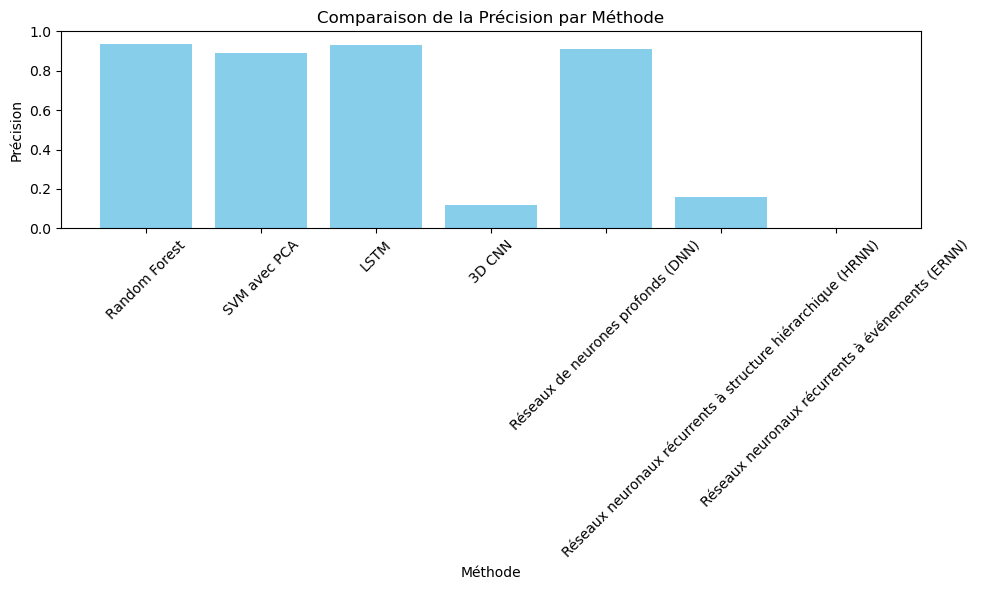

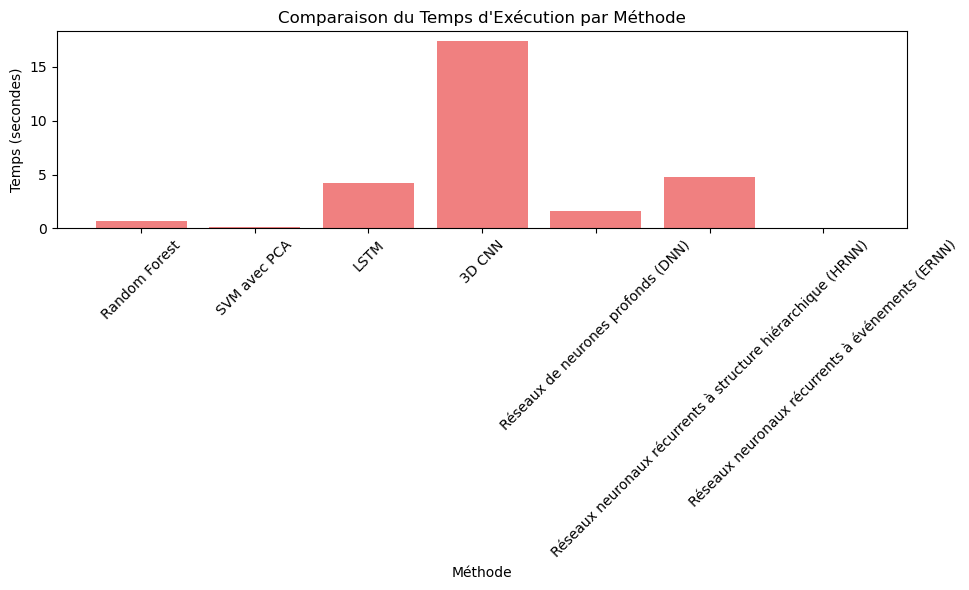

In [523]:
# 1. Graphique de comparaison de précision :

plt.figure(figsize=(10, 6))
plt.bar(comparison_results['Méthode'], comparison_results['Précision'], color='skyblue')
plt.title('Comparaison de la Précision par Méthode')
plt.xlabel('Méthode')
plt.ylabel('Précision')
plt.ylim(0, 1.0)  # Ajustez cette plage en fonction de vos données
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Graphique de comparaison de temps d'exécution :

plt.figure(figsize=(10, 6))
plt.bar(comparison_results['Méthode'], comparison_results['Temps (secondes)'], color='lightcoral')
plt.title('Comparaison du Temps d\'Exécution par Méthode')
plt.xlabel('Méthode')
plt.ylabel('Temps (secondes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
